<a href="https://colab.research.google.com/github/embordin/PNS-2019-National-Health-Survey-2019-Prediction-of-Heart-Disease-by-LGBM-Modeling-part-II/blob/main/PNS2019_HeartDisease_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose is to improve the model: https://github.com/embordin/PNS-2019-heart-diseases-prediction-LGBMClassifier 
by applying the following dimentionality reduction criteria: SHAP impact combining with factor risk for heart disease development

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install data-science-utils

In [ ]:
!pip install shap==0.39.0

In [ ]:
!pip install scikit-plot

In [ ]:
!pip install feature-engine

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import shap
import scikitplot as skplt
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from feature_engine.imputation import ArbitraryNumberImputer, MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper

import plotly.express as px
from yellowbrick.features import PCA

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import export_graphviz 
from IPython.display import Image

from yellowbrick.cluster import KElbowVisualizer
from IPython.display import Image

from sklearn import metrics
from sklearn.metrics import plot_roc_curve
from scipy.stats import ks_2samp
from sklearn.metrics import make_scorer, log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve

In [8]:
df_pns_model= pd.read_csv('/content/drive/MyDrive/tcc_files/MBA_TCC_project/Project/GitHub/df_pns_rawdata.csv', sep=',', encoding = "ISO-8859-1")
df_pns_model.drop(df_pns_model.filter(regex="Unname"),axis=1, inplace=True)
df_pns_model

,index,Workforce,State,Live,Education,Income,Gender,Age,SkinColor,OralHealth,...,OCD,COPD,Cancer,KidneyFailure,SaltConsump,Alcohol,onTV,onPhoneComput,Smoke,Smoked
0,0,Able,RO,Capital,<9y,1/4-1/2mw,Female,55.0,whrite,<1y,...,0.0,0.0,0.0,0.0,Fair,<1month,2_3h_day,<1h_day,NoSmook,YesDaily
1,9,Able,RO,Capital,<12y,1/4-1/2mw,Female,19.0,brown,<1y,...,0.0,0.0,0.0,0.0,Fair,<1month,DontSeeTV,>6h_day,YesDaily,YesDaily
2,10,Able,RO,Capital,12y,1/2-1mw,Female,45.0,black,>3y,...,0.0,0.0,0.0,0.0,Low,>=1month,1_2h_day,1_2h_day,NoSmook,YesDaily
3,18,Able,RO,Capital,<1y,1/4-1/2mw,Female,58.0,black,<1y,...,0.0,0.0,0.0,0.0,Fair,NoDrink,<1h_day,3_6h_day,NoSmook,NoSmook
4,19,Unable,RO,Capital,<16,<1/4mw,Female,28.0,brown,<1y,...,0.0,0.0,0.0,0.0,Fair,NoDrink,1_2h_day,<1h_day,NoSmook,NoSmook
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81213,285161,Able,GO,Other,<9y,1/2-1mw,Male,22.0,whrite,>3y,...,0.0,0.0,0.0,0.0,Fair,>=1month,1_2h_day,<1h_day,NoSmook,YesNotDaily
81214,285166,Able,GO,Other,<9y,1/4-1/2mw,Female,39.0,brown,1-2y,...,0.0,0.0,0.0,0.0,Much,NoDrink,1_2h_day,<1h_day,NoSmook,NoSmook
81215,285169,Unable,GO,Other,<9y,1/2-1mw,Female,71.0,brown,>3y,...,0.0,0.0,1.0,0.0,Low,NoDrink,3_6h_day,DontUseComp,NoSmook,NoSmook
81216,285172,Unable,GO,Other,<9y,1/4-1/2mw,Female,46.0,brown,>3y,...,0.0,0.0,0.0,0.0,Low,NoDrink,<1h_day,2_3h_day,NoSmook,NoSmook


In [9]:
df=df_pns_model['HeartDisease'].value_counts(normalize=True)
df = df.mul(100).round(2)
fig = px.bar(df, x='HeartDisease', width=800, height=400, color_discrete_sequence=["navy"], template="simple_white",
             title='Frequency of Heart Disease', labels={'index':'0=NoDiagnosis; 1=Diagnosis', 'HeartDisease':'% frequency'},text_auto=True)
fig.update_layout(showlegend=False, xaxis_ticksuffix = "%")
fig.update_yaxes(nticks=3)
fig.show()

In [10]:
# Numerical Variables
num_vars = ['Age','Fish','HeartDiseaseAge',  
             'PhysSport', 'BloodPresure', 'Diabetes', 'Dyslipidemia', 'PrivateHCare','StayedHospital', 'Stroke', 'AsthmaBronchitis', 'ArthritisRheumatism',
            'Backache', 'OCD','BMI', 'COPD', 'Cancer', 'KidneyFailure', 'Depresssion',]

# Categorical Variables
cat_vars = []

# Target Variable
target = 'HeartDisease'

# list of features
features = cat_vars + num_vars

# filtering features from the raw data dataset
X = df_pns_model[features]

# filtering target features
y = df_pns_model[target]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=30)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((64974, 19), (16244, 19), (64974,), (16244,))

In [12]:
#X_train_prob = X_train
X_test_prob = X_test

In [13]:
scaler = StandardScaler()
scaler.fit(X_train[num_vars])

X_train_num_scaled = pd.DataFrame(scaler.transform(X_train[num_vars]), columns=num_vars)
X_test_num_scaled = pd.DataFrame(scaler.transform(X_test[num_vars]), columns=num_vars)

In [ ]:
#ohe = OneHotEncoder(variables=cat_vars)
#X_train_cat_ohe = ohe.fit_transform(X_train[cat_vars])
#X_test_cat_ohe  = ohe.transform(X_test[cat_vars])

In [14]:
X_train_num_scaled = X_train_num_scaled.set_index(X_train.index)
X_test_num_scaled  = X_test_num_scaled.set_index(X_test.index)

#X_train_cat_ohe = X_train_cat_ohe.set_index(X_train.index)
#X_test_cat_ohe = X_test_cat_ohe.set_index(X_test.index)

In [15]:
#X_train_transformed = pd.concat([X_train_num_scaled, X_train_cat_ohe ], axis='columns')
X_train_transformed = X_train_num_scaled

In [16]:
#X_test_transformed = pd.concat([X_test_num_scaled, X_test_cat_ohe], axis='columns')
X_test_transformed = X_test_num_scaled

In [17]:
LGBM_GS_19 = Pipeline(steps=[
    ('LGBMClassifier', LGBMClassifier(random_state=42, class_weight={0:1,1:16}, learning_rate=0.025, max_depth=7, n_estimators=100))
])

skf=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

cv_results = cross_val_score(estimator=LGBM_GS_19, X=X_train_transformed, y=y_train, scoring='recall', cv=skf, n_jobs=-1)
print(cv_results.mean())

0.7125668449197861


In [18]:
LGBM_GS_19.fit(X_train_transformed, y_train)

Pipeline(steps=[('LGBMClassifier',
                 LGBMClassifier(class_weight={0: 1, 1: 16}, learning_rate=0.025,
                                max_depth=7, random_state=42))])

In [19]:
y_pred_train = LGBM_GS_19.predict(X_train_transformed)
y_proba_train = LGBM_GS_19.predict_proba(X_train_transformed)[:, 1]
print(f'RoC-AUC LGBM/GS_fs_train: {roc_auc_score(y_train, y_proba_train)}')
print(f'Recall LGBM/GS_fs_train: {recall_score(y_train, y_pred_train)}')
print(f'Precision LGBM/GS_fs_train: {precision_score(y_train, y_pred_train)}')
print(f'F1 score LGBM/GS_fs_train: {f1_score(y_train, y_pred_train)}')

RoC-AUC LGBM/GS_fs_train: 0.8016806965966794
Recall LGBM/GS_fs_train: 0.7532085561497326
Precision LGBM/GS_fs_train: 0.13896014206787688
F1 score LGBM/GS_fs_train: 0.23463268365817092


In [20]:
y_pred_test = LGBM_GS_19.predict(X_test_transformed)
y_proba_test = LGBM_GS_19.predict_proba(X_test_transformed)[:, 1]

print(f'RoC-AUC LGBM/GS_fs_test: {roc_auc_score(y_test, y_proba_test)}')
print(f'Recall LGBM/GS_fs_test: {recall_score(y_test, y_pred_test)}')
print(f'Precision LGBM/GS_fs_test: {precision_score(y_test, y_pred_test)}')
print(f'F1 score LGBM/GS_fs_test: {f1_score(y_test, y_pred_test)}')

RoC-AUC LGBM/GS_fs_test: 0.7845748775734762
Recall LGBM/GS_fs_test: 0.7286202964652223
Precision LGBM/GS_fs_test: 0.1295095257397649
F1 score LGBM/GS_fs_test: 0.21992772328342797


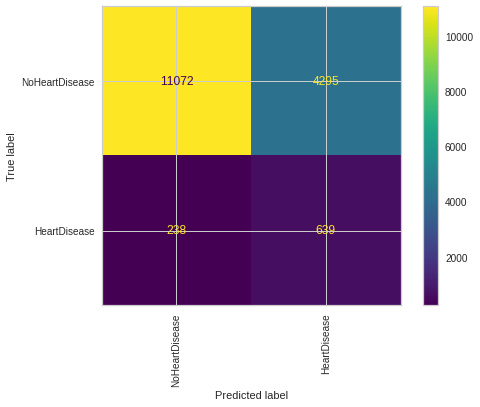

In [22]:
plot_confusion_matrix(LGBM_GS_19, X_test_transformed, y_test, values_format='d', display_labels=['NoHeartDisease', 'HeartDisease'], xticks_rotation='vertical')

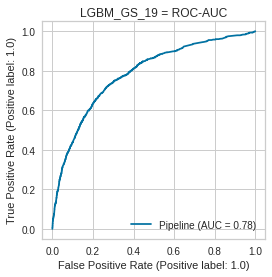

In [32]:
fig, ax = plt.subplots(figsize=(4,4))
plot_roc_curve(LGBM_GS_19, X_test_transformed, y_test, ax=ax)
ax.set_title('LGBM_GS_19 = ROC-AUC')
plt.show()

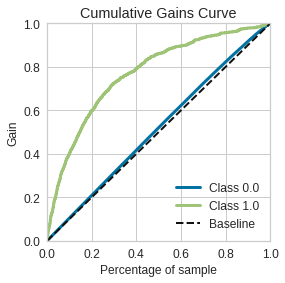

In [31]:
fig, ax = plt.subplots(figsize=(4,4))
y_probas=LGBM_GS_19.predict_proba(X_test_transformed)
skplt.metrics.plot_cumulative_gain(y_test, y_probas, ax=ax)

plt.show()

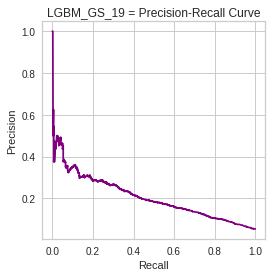

In [28]:
y_score = LGBM_GS_19.predict_proba(X_test_transformed)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

fig, ax = plt.subplots(figsize=(4,4))
ax.plot(recall, precision, color='purple')

ax.set_title('LGBM_GS_19 = Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plt.show()

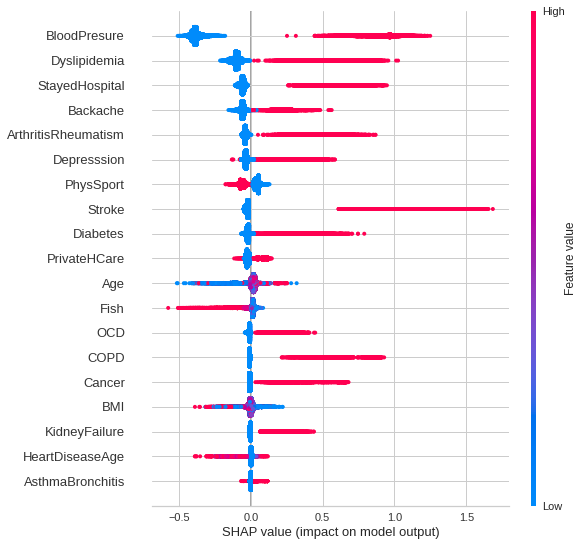

In [24]:
explainer = shap.TreeExplainer(LGBM_GS_19[-1])
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values[1], X_train_transformed, plot_type='dot', max_display=30)

100%|===================| 56844/56852 [02:03<00:00]       

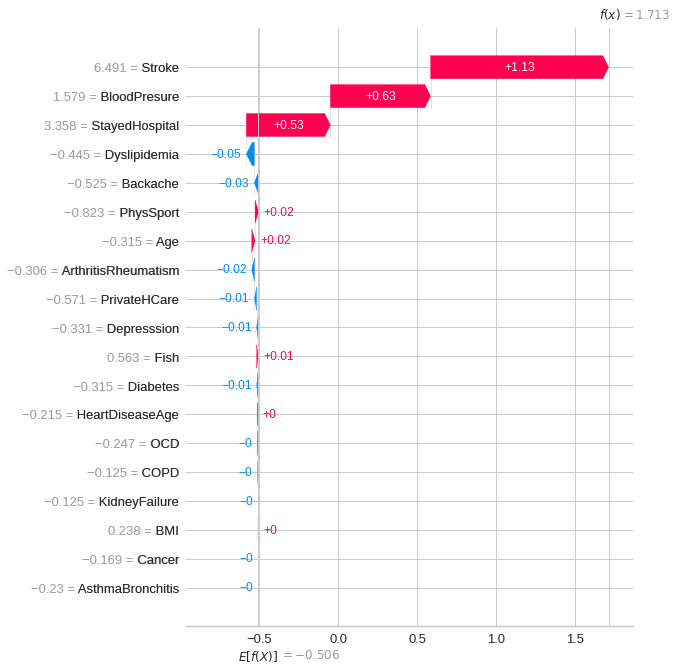

In [ ]:
explainer = shap.TreeExplainer(LGBM_GS_19[-1], X_train_transformed)
explanation_object = explainer(X_train_transformed)
shap_values = explainer.shap_values(X_train_transformed)
shap.plots.waterfall(explanation_object[1],  max_display=30)

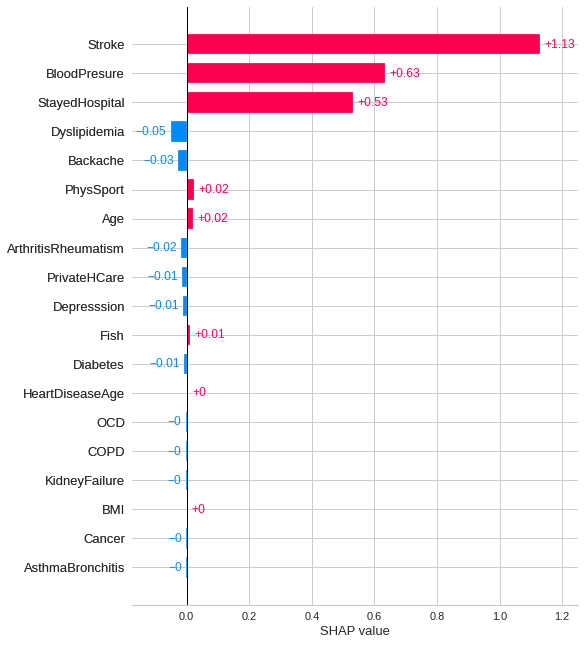

In [ ]:
shap.plots.bar(explanation_object[1], max_display=30)

In [33]:
df_prob = X_test_prob
df_prob['cardio_pred'] = LGBM_GS_19.predict(X_test_transformed)
df_prob['cardio_proba'] = LGBM_GS_19.predict_proba(X_test_transformed)[:, 1]
df_prob = pd.concat([df_prob, y_test], axis='columns')   
df_prob.head()

,Age,Fish,HeartDiseaseAge,PhysSport,BloodPresure,Diabetes,Dyslipidemia,PrivateHCare,StayedHospital,Stroke,...,Backache,OCD,BMI,COPD,Cancer,KidneyFailure,Depresssion,cardio_pred,cardio_proba,HeartDisease
11251,26.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,15.57,0.0,0.0,0.0,0.0,0.0,0.403016,0.0
61700,48.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,24.22,0.0,0.0,0.0,0.0,0.0,0.363408,1.0
69623,61.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,30.33,0.0,0.0,0.0,1.0,1.0,0.829004,0.0
14891,53.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,23.03,0.0,0.0,0.0,0.0,0.0,0.218541,0.0
37252,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,27.76,0.0,0.0,0.0,0.0,0.0,0.212233,0.0


In [34]:
def classe_prob (Q):
  if Q <= 0.10: 
    return "<10%" 
  elif Q >=0.1 and Q <0.20: 
    return "10-20%" 
  elif Q >=0.20 and Q <0.30: 
    return "20-30%" 
  elif Q >=0.30 and Q <0.40: 
    return "30-40%" 
  elif Q >=0.40 and Q<=0.50: 
    return "40-50%" 
  elif Q >=0.50 and Q<=0.60: 
    return "50-60%" 
  elif Q >=0.60 and Q <0.70: 
    return "60-70%" 
  elif Q >=0.70 and Q <0.80: 
    return "70-80%" 
  elif Q >=0.80 and Q <0.90: 
    return "80-90%" 
  elif Q >=0.90 and Q<=1: 
    return "90-100%"

df_prob1=df_prob
df_prob1["cardio_proba_range"] = df_prob1['cardio_proba'].apply(classe_prob) 
df_prob1['cardio_proba'].sort_values(ascending=False) 
df_prob1.reset_index() 
df_prob1.head(5)

,Age,Fish,HeartDiseaseAge,PhysSport,BloodPresure,Diabetes,Dyslipidemia,PrivateHCare,StayedHospital,Stroke,...,OCD,BMI,COPD,Cancer,KidneyFailure,Depresssion,cardio_pred,cardio_proba,HeartDisease,cardio_proba_range
11251,26.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,15.57,0.0,0.0,0.0,0.0,0.0,0.403016,0.0,40-50%
61700,48.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,24.22,0.0,0.0,0.0,0.0,0.0,0.363408,1.0,30-40%
69623,61.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,30.33,0.0,0.0,0.0,1.0,1.0,0.829004,0.0,80-90%
14891,53.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,23.03,0.0,0.0,0.0,0.0,0.0,0.218541,0.0,20-30%
37252,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,27.76,0.0,0.0,0.0,0.0,0.0,0.212233,0.0,20-30%


In [35]:
df_prob1=(
    df_prob
    .filter(['cardio_pred', 'cardio_proba', 'HeartDisease', 'cardio_proba_range']))
df_prob1


,cardio_pred,cardio_proba,HeartDisease,cardio_proba_range
11251,0.0,0.403016,0.0,40-50%
61700,0.0,0.363408,1.0,30-40%
69623,1.0,0.829004,0.0,80-90%
14891,0.0,0.218541,0.0,20-30%
37252,0.0,0.212233,0.0,20-30%
...,...,...,...,...
37219,0.0,0.240335,1.0,20-30%
69332,0.0,0.323450,0.0,30-40%
48875,0.0,0.409455,0.0,40-50%
40527,1.0,0.508175,0.0,50-60%


In [36]:
df_prob2 = df_prob1.groupby(['cardio_proba_range','cardio_pred']).agg(count=("cardio_pred", 'count'))
df_prob2 = df_prob2.reset_index()
df_prob2

,cardio_proba_range,cardio_pred,count
0,10-20%,0.0,468
1,20-30%,0.0,7674
2,30-40%,0.0,1529
3,40-50%,0.0,1639
4,50-60%,1.0,2105
5,60-70%,1.0,1224
6,70-80%,1.0,1174
7,80-90%,1.0,431


In [37]:
df_prob2 = df_prob1.groupby(['cardio_proba_range', 'HeartDisease', 'cardio_pred']).agg(count=("HeartDisease", 'count'))
df_prob2['count%'] = (df_prob2['count'] / df_prob2['count'].sum()).round(4) * 100
df_prob2 = df_prob2.reset_index()
df_prob2

,cardio_proba_range,HeartDisease,cardio_pred,count,count%
0,10-20%,0.0,0.0,461,2.84
1,10-20%,1.0,0.0,7,0.04
2,20-30%,0.0,0.0,7558,46.53
3,20-30%,1.0,0.0,116,0.71
4,30-40%,0.0,0.0,1472,9.06
5,30-40%,1.0,0.0,57,0.35
6,40-50%,0.0,0.0,1581,9.73
7,40-50%,1.0,0.0,58,0.36
8,50-60%,0.0,1.0,1954,12.03
9,50-60%,1.0,1.0,151,0.93


In [38]:
df_prob2['ONOFF']=df_prob2.apply(lambda x: 'ON' if x['HeartDisease'] == x['cardio_pred'] else 'OFF', axis=1)
df_prob2 = df_prob2.reset_index()
df_prob2

,index,cardio_proba_range,HeartDisease,cardio_pred,count,count%,ONOFF
0,0,10-20%,0.0,0.0,461,2.84,ON
1,1,10-20%,1.0,0.0,7,0.04,OFF
2,2,20-30%,0.0,0.0,7558,46.53,ON
3,3,20-30%,1.0,0.0,116,0.71,OFF
4,4,30-40%,0.0,0.0,1472,9.06,ON
5,5,30-40%,1.0,0.0,57,0.35,OFF
6,6,40-50%,0.0,0.0,1581,9.73,ON
7,7,40-50%,1.0,0.0,58,0.36,OFF
8,8,50-60%,0.0,1.0,1954,12.03,OFF
9,9,50-60%,1.0,1.0,151,0.93,ON


The graphic below shows the probability of accurately targeting someone to develop heart disease

In [57]:
fig = px.bar(df_prob2, x='cardio_proba_range', y='count%', color='ONOFF', width=800, height=400, template="simple_white",barmode = 'group',
             title='Probability of Targeting Heart Disease', labels={'cardio_proba_range':'Range of Probabilities', 'ONOFF': 'Target', 'count%':'frequency %'},
             text_auto=True, color_discrete_map={'ON': 'green','OFF': 'red'})
fig.update_layout(showlegend=True)
fig.show()

The model classified many people as False-Negative or all off-target with a probability higher than 50%, as shown in the graphic below. In terms of risk factors, what makes them different from others who are classified as True-Positive?

In [59]:
df_prob3=df_prob
df_prob3['ONOFF']=df_prob3.apply(lambda x: 1 if x['HeartDisease'] == x['cardio_pred'] else 0, axis=1)
df_prob3.reset_index()
df_prob3

,Age,Fish,HeartDiseaseAge,PhysSport,BloodPresure,Diabetes,Dyslipidemia,PrivateHCare,StayedHospital,Stroke,...,BMI,COPD,Cancer,KidneyFailure,Depresssion,cardio_pred,cardio_proba,HeartDisease,cardio_proba_range,ONOFF
11251,26.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,15.57,0.0,0.0,0.0,0.0,0.0,0.403016,0.0,40-50%,1
61700,48.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,24.22,0.0,0.0,0.0,0.0,0.0,0.363408,1.0,30-40%,0
69623,61.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,30.33,0.0,0.0,0.0,1.0,1.0,0.829004,0.0,80-90%,0
14891,53.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.03,0.0,0.0,0.0,0.0,0.0,0.218541,0.0,20-30%,1
37252,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.76,0.0,0.0,0.0,0.0,0.0,0.212233,0.0,20-30%,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37219,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.18,0.0,0.0,0.0,0.0,0.0,0.240335,1.0,20-30%,0
69332,65.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,37.20,0.0,0.0,0.0,1.0,0.0,0.323450,0.0,30-40%,1
48875,29.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,29.07,0.0,0.0,0.0,0.0,0.0,0.409455,0.0,40-50%,1
40527,44.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,23.62,0.0,0.0,0.0,0.0,1.0,0.508175,0.0,50-60%,0


Lower than 50% probability, predicted as Negative and HeartDisease as Positive (False-Negative)

In [60]:
df_prob10=(
    df_prob3
    .query('cardio_proba < 0.5 and ONOFF == 0')
)
df_prob10

,Age,Fish,HeartDiseaseAge,PhysSport,BloodPresure,Diabetes,Dyslipidemia,PrivateHCare,StayedHospital,Stroke,...,BMI,COPD,Cancer,KidneyFailure,Depresssion,cardio_pred,cardio_proba,HeartDisease,cardio_proba_range,ONOFF
61700,48.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,24.22,0.0,0.0,0.0,0.0,0.0,0.363408,1.0,30-40%,0
26422,26.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,33.14,0.0,0.0,0.0,0.0,0.0,0.202795,1.0,20-30%,0
76245,80.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,19.15,0.0,0.0,0.0,0.0,0.0,0.436316,1.0,40-50%,0
76170,27.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,23.50,0.0,0.0,0.0,0.0,0.0,0.405296,1.0,40-50%,0
45043,59.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,23.51,0.0,0.0,0.0,1.0,0.0,0.427220,1.0,40-50%,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75264,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24.68,0.0,0.0,0.0,0.0,0.0,0.240826,1.0,20-30%,0
51562,57.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,21.67,0.0,0.0,0.0,0.0,0.0,0.262352,1.0,20-30%,0
2882,56.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.62,0.0,0.0,0.0,0.0,0.0,0.214364,1.0,20-30%,0
23817,58.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.34,0.0,0.0,0.0,0.0,0.0,0.213380,1.0,20-30%,0


Higher than 50% probability, predicted as Positive and HeartDisease as Negative (False-Positive)


In [61]:
df_prob4=(
    df_prob3
    .query('cardio_proba > 0.5 and ONOFF == 0')
)
df_prob4

,Age,Fish,HeartDiseaseAge,PhysSport,BloodPresure,Diabetes,Dyslipidemia,PrivateHCare,StayedHospital,Stroke,...,BMI,COPD,Cancer,KidneyFailure,Depresssion,cardio_pred,cardio_proba,HeartDisease,cardio_proba_range,ONOFF
69623,61.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,30.33,0.0,0.0,0.0,1.0,1.0,0.829004,0.0,80-90%,0
36802,19.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,21.56,0.0,0.0,1.0,0.0,1.0,0.846936,0.0,80-90%,0
54023,22.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,32.66,0.0,0.0,0.0,0.0,1.0,0.538655,0.0,50-60%,0
47764,37.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,27.69,0.0,0.0,0.0,0.0,1.0,0.676508,0.0,60-70%,0
45307,52.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,30.48,0.0,0.0,0.0,0.0,1.0,0.556508,0.0,50-60%,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36003,45.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,27.01,0.0,0.0,0.0,0.0,1.0,0.562103,0.0,50-60%,0
57172,53.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,31.91,0.0,0.0,0.0,0.0,1.0,0.626313,0.0,60-70%,0
5847,17.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,25.64,0.0,0.0,0.0,0.0,1.0,0.816918,0.0,80-90%,0
10187,77.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,34.70,0.0,0.0,0.0,0.0,1.0,0.778408,0.0,70-80%,0


In [62]:
df_prob4=(
    df_prob4
    .filter(['BloodPresure', 'Diabetes', 'Dyslipidemia', 'Stroke', 'Depresssion', 'StayedHospital', 'AsthmaBronchitis', 'ArthritisRheumatism', 'Backache', 'OCD', 'COPD',
            'Cancer', 'KidneyFailure']))

df_prob4=df_prob4.replace([0.0, 1.0],['nao', 'sim'])

In [63]:
df_prob4=df_prob4.applymap(lambda x : np.where(x == 'sim', True,False))
df_prob4['SumYes']=np.where(df_prob4.sum(axis=1)>= 1, 'sim', 'nao')
df_prob4

,BloodPresure,Diabetes,Dyslipidemia,Stroke,Depresssion,StayedHospital,AsthmaBronchitis,ArthritisRheumatism,Backache,OCD,COPD,Cancer,KidneyFailure,SumYes
69623,True,False,True,True,True,False,False,False,True,False,False,False,False,sim
36802,True,False,True,True,False,False,True,True,True,False,False,False,True,sim
54023,True,False,False,False,False,False,False,False,False,False,False,False,False,sim
47764,True,False,True,False,False,False,True,False,False,False,False,False,False,sim
45307,True,False,False,False,False,False,False,False,False,False,False,False,False,sim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36003,False,True,True,False,False,False,False,False,False,False,False,False,False,sim
57172,False,True,True,False,False,False,False,False,True,False,False,False,False,sim
5847,True,False,True,False,False,True,False,True,False,False,False,False,False,sim
10187,True,False,True,False,False,False,False,True,True,False,False,False,False,sim


In [64]:
df_prob5=(df_prob4.value_counts('BloodPresure'), df_prob4.value_counts('Diabetes'), df_prob4.value_counts('Dyslipidemia'),
          df_prob4.value_counts('Stroke'), df_prob4.value_counts('Depresssion'), df_prob4.value_counts('StayedHospital'), df_prob4.value_counts('AsthmaBronchitis'), 
          df_prob4.value_counts('ArthritisRheumatism'), df_prob4.value_counts('Backache'), df_prob4.value_counts('OCD'), df_prob4.value_counts('COPD'),
          df_prob4.value_counts('Cancer'), df_prob4.value_counts('KidneyFailure'))
          

df_prob5=pd.DataFrame(df_prob5, index=(['BloodPresure','Diabetes',  'Dyslipidemia','Stroke','Depresssion','StayedHospital','AsthmaBronchitis','ArthritisRheumatism','backache', 'OCD', 'COPD', 'Cancer', 'KidneyFailure' ]))
df_prob5['%sim']=(df_prob5[1]/(df_prob5[1]+df_prob5[0])*100).round(2)
df_prob5.reset_index(inplace=True)
df_prob5.sort_values(by="%sim", ascending=False)

,index,True,False,%sim
0,BloodPresure,3482,813,81.07
2,Dyslipidemia,1620,2675,37.72
8,backache,1595,2700,37.14
1,Diabetes,902,3393,21.00
7,ArthritisRheumatism,809,3486,18.84
4,Depresssion,788,3507,18.35
5,StayedHospital,656,3639,15.27
9,OCD,378,3917,8.80
3,Stroke,300,3995,6.98
6,AsthmaBronchitis,256,4039,5.96


In [75]:

fig = px.bar(df_prob5, x='index', y='%sim', width=800, height=400, color_discrete_sequence=["olive"], template="simple_white",
             title='Frequency of Risk Factor for False-Positive', labels={'index': 'variables', '%sim' : '% Frequency'},text_auto=True,
             category_orders={'index': ['BloodPresure', 'backache', 'Dyslipidemia', 'ArthritisRheumatism', 'Diabetes', 'StayedHospital', 'Depresssion', 'Stroke',
                                        'OCD', 'AsthmaBronchitis', 'Cancer', 'COPD', 'KidneyFailure']})
             
fig.update_layout(showlegend=False)
fig.update_yaxes(nticks=3)
fig.show()

Higher than 50% probability, predicted as Positive and Heart Disease as Positive (True-Positive)

In [66]:
df_prob6=(
    df_prob3
    .query('cardio_proba > 0.5 and ONOFF == 1')
)
df_prob6

,Age,Fish,HeartDiseaseAge,PhysSport,BloodPresure,Diabetes,Dyslipidemia,PrivateHCare,StayedHospital,Stroke,...,BMI,COPD,Cancer,KidneyFailure,Depresssion,cardio_pred,cardio_proba,HeartDisease,cardio_proba_range,ONOFF
70676,37.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,27.76,0.0,0.0,0.0,1.0,1.0,0.726516,1.0,70-80%,1
21274,21.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,22.15,0.0,0.0,0.0,0.0,1.0,0.859382,1.0,80-90%,1
52365,59.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,26.50,0.0,0.0,0.0,0.0,1.0,0.733040,1.0,70-80%,1
9693,22.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,18.37,0.0,0.0,0.0,0.0,1.0,0.709768,1.0,70-80%,1
76244,54.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,23.31,0.0,0.0,0.0,0.0,1.0,0.533043,1.0,50-60%,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50777,31.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,24.77,0.0,1.0,0.0,0.0,1.0,0.789377,1.0,70-80%,1
62305,35.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,29.84,0.0,0.0,0.0,1.0,1.0,0.862223,1.0,80-90%,1
53487,56.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,28.41,0.0,0.0,0.0,0.0,1.0,0.510630,1.0,50-60%,1
55715,28.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,30.80,0.0,0.0,0.0,0.0,1.0,0.648896,1.0,60-70%,1


In [67]:
df_prob6=(
    df_prob6
    .filter(['BloodPresure', 'Diabetes', 'Dyslipidemia', 'Stroke', 'Depresssion', 'StayedHospital', 'AsthmaBronchitis', 'ArthritisRheumatism', 'Backache', 'OCD', 'COPD',
            'Cancer', 'KidneyFailure']))

df_prob6=df_prob6.replace([0.0, 1.0],['nao', 'sim'])

In [68]:
df_prob6=df_prob6.applymap(lambda x : np.where(x == 'sim', True,False))
df_prob6['sim']=np.where(df_prob6.sum(axis=1)>= 1, 'sim', 'nao')
df_prob6

,BloodPresure,Diabetes,Dyslipidemia,Stroke,Depresssion,StayedHospital,AsthmaBronchitis,ArthritisRheumatism,Backache,OCD,COPD,Cancer,KidneyFailure,sim
70676,True,False,True,False,True,False,False,False,True,False,False,False,False,sim
21274,True,True,True,True,False,True,False,False,False,False,False,False,False,sim
52365,True,False,True,False,False,False,False,True,False,False,False,False,False,sim
9693,True,False,True,False,False,False,False,True,False,False,False,False,False,sim
76244,True,False,False,False,False,False,False,False,False,False,False,False,False,sim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50777,False,False,False,True,False,True,False,False,False,False,False,True,False,sim
62305,True,False,False,True,True,True,True,False,False,False,False,False,False,sim
53487,True,False,False,False,False,False,False,False,False,False,False,False,False,sim
55715,False,False,False,True,False,False,False,False,False,False,False,False,False,sim


In [69]:
df_prob7=(df_prob6.value_counts('BloodPresure'), df_prob6.value_counts('Diabetes'), df_prob6.value_counts('Dyslipidemia'),
          df_prob6.value_counts('Stroke'), df_prob6.value_counts('Depresssion'), df_prob6.value_counts('StayedHospital'), df_prob6.value_counts('AsthmaBronchitis'), 
          df_prob6.value_counts('ArthritisRheumatism'), df_prob6.value_counts('Backache'), df_prob6.value_counts('OCD'), df_prob6.value_counts('COPD'),
          df_prob6.value_counts('Cancer'), df_prob6.value_counts('KidneyFailure'))
          

df_prob7=pd.DataFrame(df_prob7, index=(['BloodPresure','Diabetes',  'Dyslipidemia','Stroke','Depresssion','StayedHospital','AsthmaBronchitis','ArthritisRheumatism','backache', 'OCD', 'COPD', 'Cancer', 'KidneyFailure' ]))
df_prob7['%sim']=(df_prob7[1]/(df_prob7[1]+df_prob7[0])*100).round(2)
df_prob7.reset_index(inplace=True)
df_prob7.sort_values(by="%sim", ascending=False)

,index,True,False,%sim
0,BloodPresure,551,88,86.23
8,backache,296,343,46.32
2,Dyslipidemia,288,351,45.07
7,ArthritisRheumatism,199,440,31.14
1,Diabetes,195,444,30.52
5,StayedHospital,186,453,29.11
4,Depresssion,157,482,24.57
3,Stroke,98,541,15.34
9,OCD,81,558,12.68
11,Cancer,62,577,9.70


In [74]:
fig = px.bar(df_prob7, x='index', y='%sim', width=800, height=400, color_discrete_sequence=["olive"], template="simple_white",
             title='Frequency of Risk Factor for True-Positive  ', labels={'index': 'Variables', '%sim' : '% Frequency'},text_auto=True,
             category_orders={'index': ['BloodPresure','Dyslipidemia','backache','Diabetes','ArthritisRheumatism','StayedHospital', 'Depresssion', 'Stroke','OCD','AsthmaBronchitis',   
                                          'Cancer', 'COPD', 'KidneyFailure',]})
             
fig.update_layout(showlegend=False)
fig.update_yaxes(nticks=3)
fig.show()

In [71]:
df_prob6=(
    df_prob3
    .filter(['Age', 'Fish', 'PhysSport', 'BMI', 'cardio_proba_range']))

df_prob6


,Age,Fish,PhysSport,BMI,cardio_proba_range
11251,26.0,2.0,0.0,15.57,40-50%
61700,48.0,3.0,1.0,24.22,30-40%
69623,61.0,0.0,0.0,30.33,80-90%
14891,53.0,4.0,0.0,23.03,20-30%
37252,26.0,0.0,0.0,27.76,20-30%
...,...,...,...,...,...
37219,24.0,0.0,0.0,23.18,20-30%
69332,65.0,1.0,1.0,37.20,30-40%
48875,29.0,1.0,0.0,29.07,40-50%
40527,44.0,1.0,0.0,23.62,50-60%


In [72]:
fig1 = px.pie(df_prob6, values='Fish', names='cardio_proba_range',
             title='Frequência de Consumo de Peixe entre os Positivos',
             labels={'cardio_proba_range':'Range de Chance para Doenças do Coração'})
fig1.update_traces(textposition='inside', textinfo='percent+label')
fig1.show()
fig2 = px.pie(df_prob6, values='BMI', names='cardio_proba_range',
             title='Frequência IMC entre os Positivos',
             labels={'cardio_proba_range':'Range de Chance para Doenças do Coração'})
fig2.update_traces(textposition='inside', textinfo='percent+label')
fig2.show()


In [73]:
#df_prob6=df_prob3['Age'].value_counts(normalize=True)
#df_prob6 = df_prob6.mul(100).round(2)
fig = px.histogram(df_prob6, x='Age', width=800, height=400, color_discrete_sequence=["olive"], template="simple_white",
             title='Frequência dos Fatores de Riscos nos Falso Negativo ', labels={'index': 'Variáveis', '%sim' : '% Frequência'},text_auto=True,
             category_orders={'index': ['BloodPresure', 'backache', 'Dyslipidemia', 'ArthritisRheumatism', 'Diabetes', 'StayedHospital', 'Depresssion', 'Stroke',
                                        'OCD', 'AsthmaBronchitis', 'Cancer', 'COPD', 'KidneyFailure']})
             
fig.update_layout(showlegend=False)
fig.update_yaxes(nticks=3)
fig.show()